In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from patsy import dmatrices
import pymc3 as pm

from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
# NSW Data Files (Dehejia-Wahha Sample)
# http://users.nber.org/~rdehejia/data/nswdata2.html

cps = pd.read_csv('data/lalonde/cps_controls.txt', delimiter='  ', names=[
        'treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr',
        're74', 're75', 're78'
    ])

original_treatment = pd.read_csv('data/lalonde/nswre74_treated.txt', delimiter='  ', names=[
        'treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr',
        're74', 're75', 're78'        
    ])

unmatched_raw = pd.concat([
        cps, original_treatment
    ], axis=0)

unmatched_raw['u74'] = (unmatched_raw.re74 == 0).astype(np.int32)
unmatched_raw['u75'] = (unmatched_raw.re75 == 0).astype(np.int32)

unmatched_raw[['re74_div', 're75_div', 're78_div']] = unmatched_raw[['re74', 're75', 're78']] / 1000

unmatched_raw.shape

/Users/penglish/.virtualenvs/data3/lib/python3.5/site-packages/ipykernel/__main__.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/penglish/.virtualenvs/data3/lib/python3.5/site-packages/ipykernel/__main__.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


(16177, 15)

In [3]:
unmatched_raw.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,re74_div,re75_div,re78_div
0,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.670,25243.550,25564.670,0,0,21.516670,25.243550,25.564670
1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.971,5852.565,13496.080,0,0,3.175971,5.852565,13.496080
2,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.020,25130.760,25564.670,0,0,23.039020,25.130760,25.564670
3,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.370,25243.550,25564.670,0,0,24.994370,25.243550,25.564670
4,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295,10727.610,9860.869,0,0,1.669295,10.727610,9.860869


In [4]:
print(unmatched_raw.head().to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>treat</th>
      <th>age</th>
      <th>educ</th>
      <th>black</th>
      <th>hisp</th>
      <th>married</th>
      <th>nodegr</th>
      <th>re74</th>
      <th>re75</th>
      <th>re78</th>
      <th>u74</th>
      <th>u75</th>
      <th>re74_div</th>
      <th>re75_div</th>
      <th>re78_div</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.0</td>
      <td>45.0</td>
      <td>11.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>21516.670</td>
      <td>25243.550</td>
      <td>25564.670</td>
      <td>0</td>
      <td>0</td>
      <td>21.516670</td>
      <td>25.243550</td>
      <td>25.564670</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.0</td>
      <td>21.0</td>
      <td>14.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>3175.971</td>
      <td>5852

In [5]:
unmatched_raw.tail()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,re74_div,re75_div,re78_div
180,1.0,33.0,12.0,1.0,0.0,1.0,0.0,20279.95,10941.35,15952.600,0,0,20.27995,10.94135,15.952600
181,1.0,25.0,14.0,1.0,0.0,1.0,0.0,35040.07,11536.57,36646.950,0,0,35.04007,11.53657,36.646950
182,1.0,35.0,9.0,1.0,0.0,1.0,1.0,13602.43,13830.64,12803.970,0,0,13.60243,13.83064,12.803970
183,1.0,35.0,8.0,1.0,0.0,1.0,1.0,13732.07,17976.15,3786.628,0,0,13.73207,17.97615,3.786628
184,1.0,33.0,11.0,1.0,0.0,1.0,1.0,14660.71,25142.24,4181.942,0,0,14.66071,25.14224,4.181942


/Users/penglish/.virtualenvs/data3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


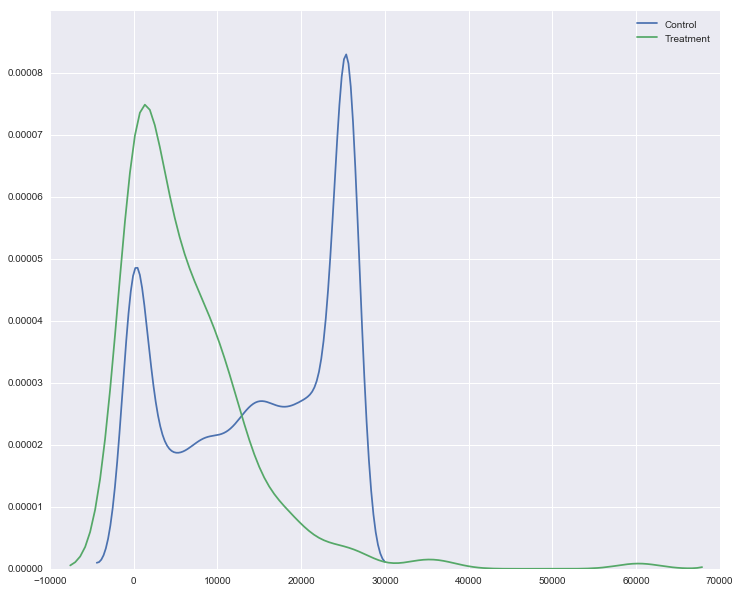

In [6]:
sns.kdeplot(unmatched_raw[unmatched_raw.treat == 0].re78, label='Control')
sns.kdeplot(unmatched_raw[unmatched_raw.treat == 1].re78, label='Treatment');

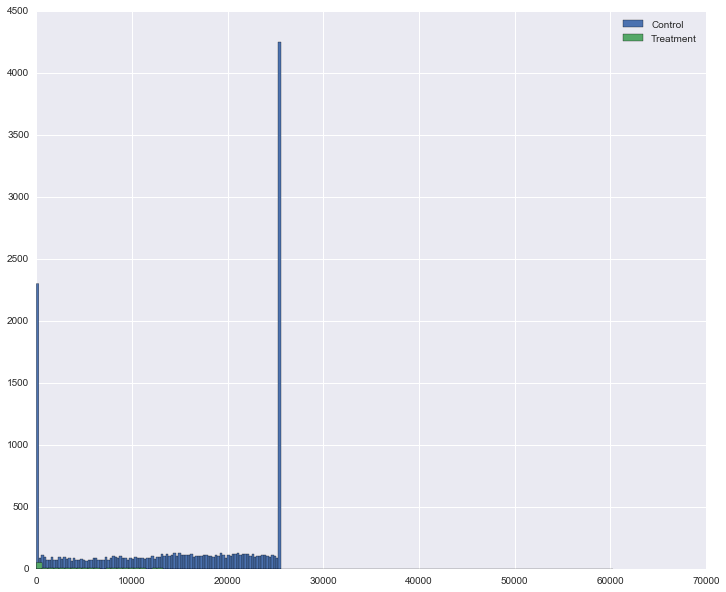

In [7]:
plt.hist(unmatched_raw[unmatched_raw.treat == 0].re78, label='Control', bins=100);
plt.hist(unmatched_raw[unmatched_raw.treat == 1].re78, label='Treatment', bins=100);
plt.legend();

# Using the `causalinference` library

In [8]:
from causalinference import CausalModel

In [9]:
causal_model = CausalModel(
    X=unmatched_raw[['age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74_div', 're75_div', 'u74', 'u75']].values, 
    D=unmatched_raw.treat.values,
    Y=unmatched_raw.re78_div.values
)
causal_model.est_propensity()
causal_model.trim_s()
causal_model.stratify_s()
causal_model.est_via_ols()
causal_model.est_via_matching(bias_adj=True)
causal_model.est_via_weighting()
print(causal_model.summary_stats)
print(causal_model.estimates)
print(causal_model.propensity)
print(causal_model.strata)


Summary Statistics

                       Controls (N_c=372)         Treated (N_t=149)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        4.812        6.092        6.038        8.006        1.226

                       Controls (N_c=372)         Treated (N_t=149)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       26.403       11.058       25.765        7.355       -0.068
             X1       10.597        2.701       10.221        2.066       -0.156
             X2        0.882        0.323        0.973        0.162        0.357
             X3        0.118        0.323        0.027        0.162       -0.357
             X4        0.215        0.411        0.134        0.342       -0.214
      

## Using our own Bayesian Model

For $y \in \mathbb{R}$, and $\mathbf{x} \in \mathbb{R}^M$

For $N$ data points, we have $(\mathbf{X}, \mathbf{y}) = \{(\mathbf{x}_n, y_n)\}$.

With the following distributions

$$
\begin{align*}
p(\mathbf{w}) &= \mathcal{N}(\mathbf{w} | 0, \sigma_w^2 \mathbf{I}) \\
p(b) &= \mathcal{N}(b | 0, \sigma_b^2) \\
p(\mathbf{y} | \mathbf{w}, b, \mathbf{X}) &= \prod_{n=1}^N \mathcal{N} (y_n | \mathbf{x}_n^{\intercal} \mathbf{w} + b, \sigma_y^2)
\end{align*}
$$

## Propensity Matching

In [10]:
propensity_formula = "treat ~ age + educ + black + hisp + married + nodegr + u74 + u75 + re75_div + re74_div + I(re74_div*re75_div)"

In [11]:
propensity_model = smf.glm(formula=propensity_formula, data=unmatched_raw, family=sm.families.Binomial()).fit()
propensity_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  treat   No. Observations:                16177
Model:                            GLM   Df Residuals:                    16165
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -473.41
Date:                Sat, 26 Nov 2016   Deviance:                       946.82
Time:                        15:09:24   Pearson chi2:                 8.10e+03
No. Iterations:                    14                                         
==========================================================================================
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -6.6364      0.825     -8.045      0.000        -8.253    -5.020
age                       -0.0191      0.011     -1.788      0.074        -0.040     0.002
educ                       0.0195      0.048      0.404      0.686        -0.075     0.114
black                      4.2899      0.263     16.329      0.000         3.775     4.805
hisp                       1.8322      0.394      4.655      0.000         1.061     2.604
married                   -0.9954      0.240     -4.147      0.000        -1.466    -0.525
nodegr                     0.9100      0.274      3.318      0.001         0.372     1.448
u74                        1.7318      0.280      6.178      0.000         1.182     2.281
u75                        0.3934      0.253      1.555      0.120        -0.102     0.889
re75_div                  -0.0871      0.056     -1.559      0.119        -0.197     0.022
re74_div                   0.0985      0.033      2.968      0.003         0.033     0.164
I(re74_div * re75_div)    -0.0072      0.004     -1.800      0.072        -0.015     0.001
==========================================================================================
"""

In [12]:
_, X_propensity = dmatrices(propensity_formula, unmatched_raw, return_type='dataframe')

In [13]:
propensities = propensity_model.predict(exog=X_propensity)

In [14]:
(propensities < 0.5).sum()

16069

In [15]:
(propensities > 0.5).sum()

108

In [16]:
unmatched_raw.iloc[propensities > 0.5].treat.sum()

59.0

In [17]:
split = cps.shape[0]

In [18]:
propensities

array([  1.14167739e-05,   8.28539725e-04,   4.84711281e-06, ...,
         1.54944295e-02,   7.06815725e-03,   1.90132316e-03])

In [19]:
treatment = np.expand_dims(propensities[split:], 1)
control = np.expand_dims(propensities[:split], 1)

treatment.shape, control.shape

((185, 1), (15992, 1))

In [20]:
distances = cdist(treatment, control)

In [21]:
distances.shape

(185, 15992)

In [22]:
treatment_idx, control_idx = linear_sum_assignment(distances)
treatment_idx, control_idx

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [23]:
treatment_data = unmatched_raw[split:].iloc[treatment_idx]
control_data = unmatched_raw[:split].iloc[control_idx]
print(treatment_data.head())
print('----')
print(control_data.head())

   treat   age  educ  black  hisp  married  nodegr  re74  re75        re78  \
0    1.0  37.0  11.0    1.0   0.0      1.0     1.0   0.0   0.0   9930.0460   
1    1.0  22.0   9.0    0.0   1.0      0.0     1.0   0.0   0.0   3595.8940   
2    1.0  30.0  12.0    1.0   0.0      0.0     0.0   0.0   0.0  24909.4500   
3    1.0  27.0  11.0    1.0   0.0      0.0     1.0   0.0   0.0   7506.1460   
4    1.0  33.0   8.0    1.0   0.0      0.0     1.0   0.0   0.0    289.7899   

   u74  u75  re74_div  re75_div   re78_div  
0    1    1       0.0       0.0   9.930046  
1    1    1       0.0       0.0   3.595894  
2    1    1       0.0       0.0  24.909450  
3    1    1       0.0       0.0   7.506146  
4    1    1       0.0       0.0   0.289790  
----
       treat   age  educ  black  hisp  married  nodegr      re74      re75  \
11544    0.0  46.0  11.0    1.0   0.0      1.0     1.0     0.000     0.000   
6044     0.0  21.0  12.0    1.0   0.0      0.0     0.0  7012.216  1389.290   
15083    0.0  17.0  12

/Users/penglish/.virtualenvs/data3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


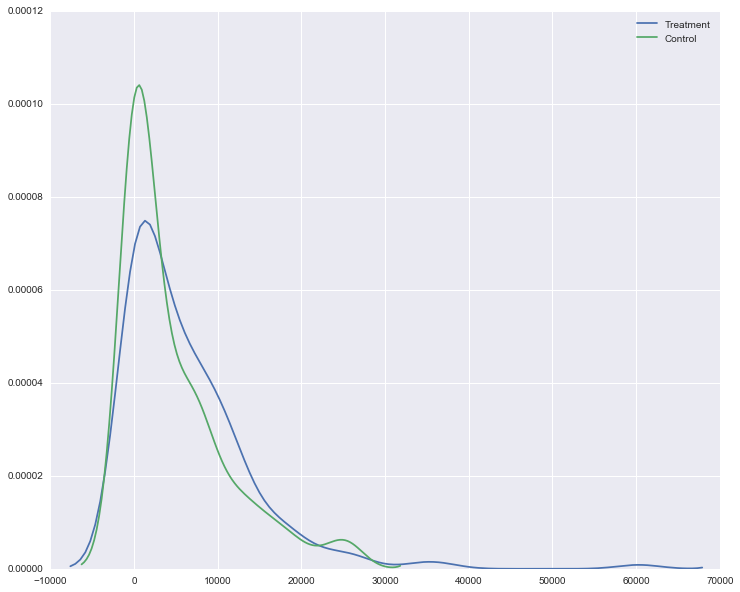

In [24]:
sns.kdeplot(treatment_data.re78, label='Treatment')
sns.kdeplot(control_data.re78, label='Control')

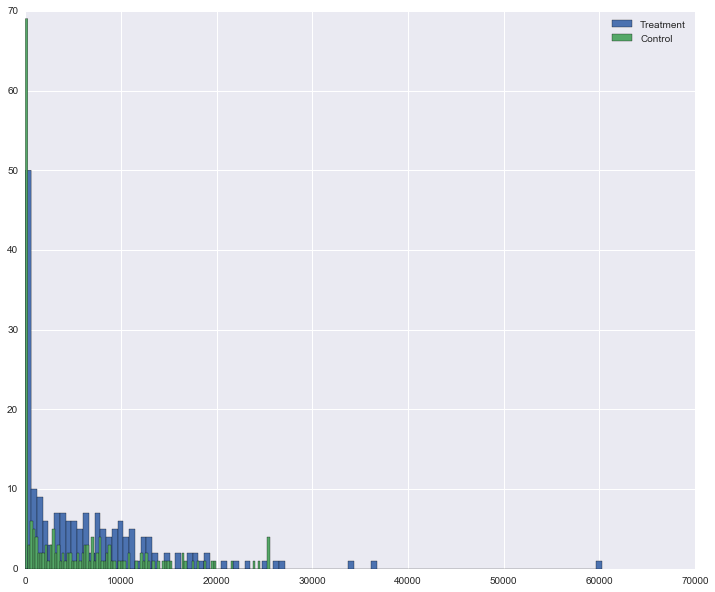

In [25]:
plt.hist(treatment_data.re78, label='Treatment', bins=100)
plt.hist(control_data.re78, label='Control', bins=100)
plt.legend();

In [26]:
data_propensity_matched = pd.concat([
        treatment_data,
        control_data
        ], axis=0)
data_propensity_matched.shape

(370, 15)

In [27]:
causal_formula = "re78_div ~ treat + age + educ + black + hisp + married + nodegr + u74 + u75 + re74_div + re75_div"

Applied log-transform to sd and added transformed sd_log_ to model.
INFO:pymc3:Applied log-transform to sd and added transformed sd_log_ to model.


ADVI
Iteration 0 [0%]: ELBO = -45564.78
Iteration 8000 [10%]: Average ELBO = -179941.26
Iteration 16000 [20%]: Average ELBO = -1669.65
Iteration 24000 [30%]: Average ELBO = -1434.98
Iteration 32000 [40%]: Average ELBO = -1425.37
Iteration 40000 [50%]: Average ELBO = -1424.45
Iteration 48000 [60%]: Average ELBO = -1424.24
Iteration 56000 [70%]: Average ELBO = -1423.82
Iteration 64000 [80%]: Average ELBO = -1423.97
Iteration 72000 [90%]: Average ELBO = -1423.87
Finished [100%]: Average ELBO = -1423.64
Sampling


100%|██████████| 2000/2000 [00:21<00:00, 94.80it/s]


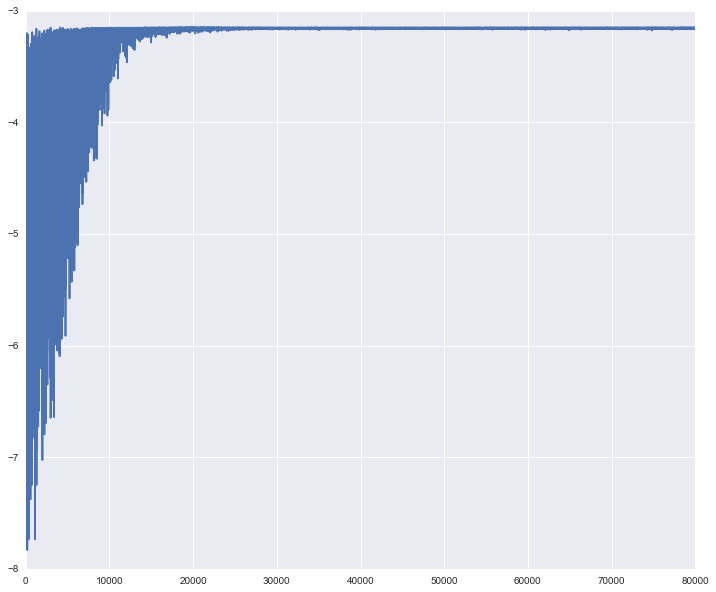

In [28]:
with pm.Model() as model:
    pm.glm.glm(causal_formula, data_propensity_matched)

    print('ADVI')
    propensity_v_params = pm.variational.advi(n=80000)
    plt.plot(-np.log10(-propensity_v_params.elbo_vals))

    print('Sampling')
    propensity_samples = pm.sample(
        2000, 
        step=pm.NUTS(scaling=propensity_v_params.means),
        start=propensity_v_params.means, 
        progressbar=True,
        njobs=3
    )

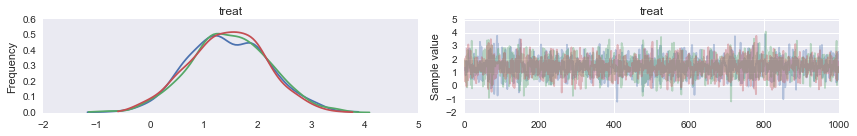

In [57]:
pm.traceplot(propensity_samples[1000:], varnames=['treat']);

In [30]:
df_propensity_samples = pm.trace_to_dataframe(propensity_samples[1000:])
df_propensity_samples.mean(0)

age         -0.046268
nodegr      -0.380227
educ         0.385656
u74          1.459713
Intercept    2.051145
u75         -0.343626
hisp         0.218121
married     -0.473846
re75_div     0.323274
re74_div     0.233762
treat        1.463496
sd           6.977029
black       -1.679199
dtype: float64

In [31]:
(df_propensity_samples['treat'] > 0).mean()

0.97499999999999998

## Mahalanobis Distance Matching

In [32]:
treatment = X_propensity[split:]
control = X_propensity[:split]

treatment.shape, control.shape

((185, 12), (15992, 12))

In [33]:
VI = np.diag(X_propensity.var())

In [34]:
distances = cdist(treatment, control, 'mahalanobis', VI=VI)

In [35]:
distances.shape

(185, 15992)

In [36]:
distances

array([[ 135182.83510144,    4629.92585063,  144100.509151  , ...,
            673.31701397,   47926.4099961 ,   44585.87728064],
       [ 135183.04471441,    4626.58455289,  144100.61715248, ...,
            693.41719141,   47927.07679146,   44586.3075516 ],
       [ 135182.90766673,    4627.61883146,  144100.53574859, ...,
            677.72824829,   47926.65059974,   44586.00185903],
       ..., 
       [  88360.21911782,   42196.73277318,   97277.86339938, ...,
          46149.73156054,    1112.10744682,    2237.57752433],
       [  73745.95007714,   56810.93390543,   82663.58549857, ...,
          60764.00520928,   13511.5796488 ,   16851.29273563],
       [  43443.74345557,   87113.18102854,   52361.28752152, ...,
          91066.3650603 ,   43813.5280718 ,   47153.64447944]])

In [37]:
treatment_idx, control_idx = linear_sum_assignment(distances)
treatment_idx, control_idx

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [38]:
treatment_data = unmatched_raw[split:].iloc[treatment_idx]
control_data = unmatched_raw[:split].iloc[control_idx]
print(treatment_data.head())
print('----')
print(control_data.head())

   treat   age  educ  black  hisp  married  nodegr  re74  re75        re78  \
0    1.0  37.0  11.0    1.0   0.0      1.0     1.0   0.0   0.0   9930.0460   
1    1.0  22.0   9.0    0.0   1.0      0.0     1.0   0.0   0.0   3595.8940   
2    1.0  30.0  12.0    1.0   0.0      0.0     0.0   0.0   0.0  24909.4500   
3    1.0  27.0  11.0    1.0   0.0      0.0     1.0   0.0   0.0   7506.1460   
4    1.0  33.0   8.0    1.0   0.0      0.0     1.0   0.0   0.0    289.7899   

   u74  u75  re74_div  re75_div   re78_div  
0    1    1       0.0       0.0   9.930046  
1    1    1       0.0       0.0   3.595894  
2    1    1       0.0       0.0  24.909450  
3    1    1       0.0       0.0   7.506146  
4    1    1       0.0       0.0   0.289790  
----
       treat   age  educ  black  hisp  married  nodegr  re74  re75      re78  \
5986     0.0  37.0  10.0    0.0   0.0      1.0     1.0   0.0   0.0     0.000   
10767    0.0  22.0   9.0    0.0   0.0      1.0     1.0   0.0   0.0     0.000   
1658     0.0  30

/Users/penglish/.virtualenvs/data3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


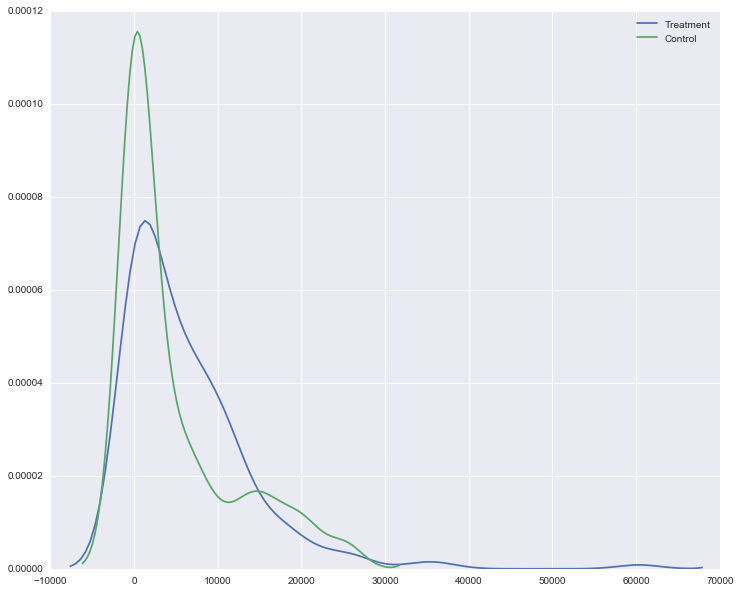

In [54]:
sns.kdeplot(treatment_data.re78, label='Treatment')
sns.kdeplot(control_data.re78, label='Control');

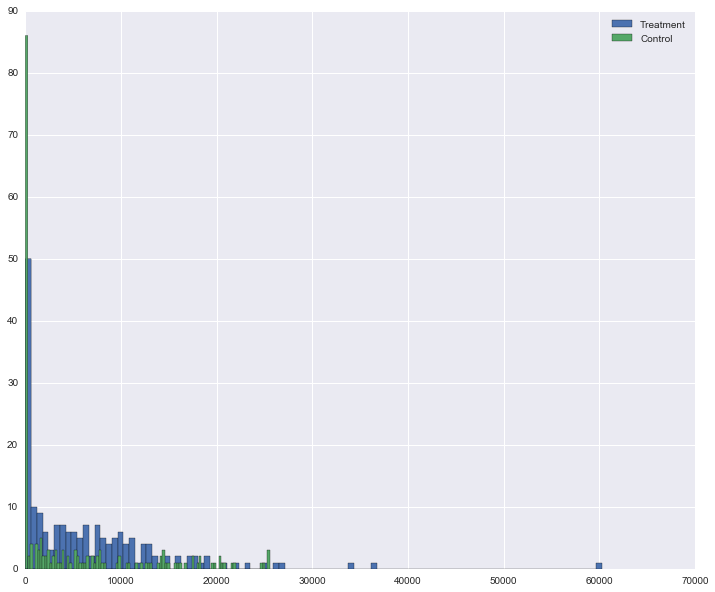

In [53]:
plt.hist(treatment_data.re78, label='Treatment', bins=100)
plt.hist(control_data.re78, label='Control', bins=100)
plt.legend();

In [41]:
data_mahalanobis_matched = pd.concat([
        treatment_data,
        control_data
        ], axis=0)
data_mahalanobis_matched.shape

(370, 15)

Applied log-transform to sd and added transformed sd_log_ to model.
INFO:pymc3:Applied log-transform to sd and added transformed sd_log_ to model.


ADVI
Iteration 0 [0%]: ELBO = -16156.39
Iteration 8000 [10%]: Average ELBO = -216377.4
Iteration 16000 [20%]: Average ELBO = -1637.49
Iteration 24000 [30%]: Average ELBO = -1434.52
Iteration 32000 [40%]: Average ELBO = -1425.37
Iteration 40000 [50%]: Average ELBO = -1424.39
Iteration 48000 [60%]: Average ELBO = -1424.08
Iteration 56000 [70%]: Average ELBO = -1424.0
Iteration 64000 [80%]: Average ELBO = -1423.79
Iteration 72000 [90%]: Average ELBO = -1423.99
Finished [100%]: Average ELBO = -1423.85
Sampling


100%|██████████| 2000/2000 [00:21<00:00, 93.26it/s]


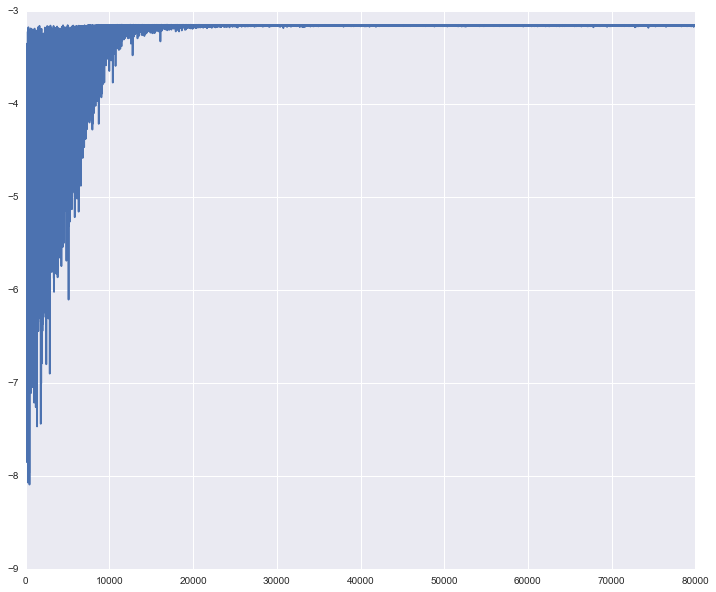

In [42]:
with pm.Model() as model:
    pm.glm.glm(causal_formula, data_propensity_matched)

    print('ADVI')
    mahalanobis_v_params = pm.variational.advi(n=80000)
    plt.plot(-np.log10(-mahalanobis_v_params.elbo_vals))

    print('Sampling')
    mahalanobis_samples = pm.sample(
        2000, 
        step=pm.NUTS(scaling=mahalanobis_v_params.means),
        start=mahalanobis_v_params.means, 
        progressbar=True,
        njobs=4
    )

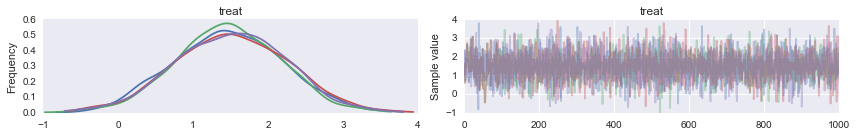

In [58]:
pm.traceplot(mahalanobis_samples[1000:], varnames=['treat']);

In [44]:
df_mahalanobis_samples = pm.trace_to_dataframe(mahalanobis_samples[1000:])
df_mahalanobis_samples.mean(0)

age         -0.045524
nodegr      -0.404798
educ         0.382626
u74          1.406951
Intercept    2.089522
u75         -0.377069
hisp         0.218565
married     -0.501467
re75_div     0.326605
re74_div     0.229498
treat        1.490877
sd           6.975974
black       -1.652019
dtype: float64

In [45]:
(df_mahalanobis_samples['treat'] > 0).mean()

0.97799999999999998

# Bonus - Estimating the counterfactual observations

Suppose we build two models,

$$
\begin{aligned}
\hat{Y}_1(1) &= \alpha_1 + \beta_1 X_i(1) + \epsilon_i \\
\hat{Y}_0(0) &= \alpha_0 + \beta_0 X_i(0) + \epsilon_i
\end{aligned}
$$

where the coefficients of $\hat{Y}_1$ are learned exclusively on samples of $X$ where we've observed $Y(1)$, and those of $\hat{Y}_2$ are likewise are learned from samples where $Y(0)$.

In [46]:
treatment_propensity = data_propensity_matched[data_propensity_matched.treat == 1]
control_propensity = data_propensity_matched[data_propensity_matched.treat == 0]

In [47]:
formula = 're78_div ~ age + educ + black + hisp + married + nodegr + u74 + u75 + re74_div + re75_div'

In [48]:
treatment_model = smf.glm(formula=formula, data=treatment_propensity).fit()

In [49]:
control_model = smf.glm(formula=formula, data=control_propensity).fit()

Now, looking back at the fundamental problem of causal inference, we want to estimate what the counterfactual outcomes would be, e.g. fill in the gaps.

What if we swap our data and estimate the effect from the two groups using the corresponding models?

$$
\begin{align*}
\hat{Y}_1(0) = \alpha_1 + \beta_1 X_i(0) + \epsilon_i \\
\hat{Y}_0(1) = \alpha_0 + \beta_0 X_i(1) + \epsilon_i
\end{align*}
$$

In [50]:
Y_treatment, X_treatment = dmatrices(causal_formula, treatment_propensity, return_type='dataframe')
Y_control, X_control = dmatrices(causal_formula, control_propensity, return_type='dataframe')

In [51]:
Y_0 = np.expand_dims(treatment_model.predict(exog=X_control), 1)
Y_1 = np.expand_dims(control_model.predict(exog=X_treatment), 1)

Now we can define $\hat{\tau}_i = Y_i - \hat{Y}_1(0)$ for our control group, and $\hat{\tau}_i = \hat{Y}_0(1) - Y_i$ for our treatment group.

We can then calculate average treatment effect as $\hat{\tau} = \frac{1}{N} \sum_{i=1}^N \hat{\tau}_i$.

In [52]:
np.concatenate([
    (Y_treatment - Y_1),    
    (Y_0 - Y_control)        
]).mean()

1.5483643168987649

Why does this work?

# References

- Lalonde, R. J. (1986). Evaluating the Econometric Evaluations of Training Programs with Experimental Data. Journal of Chemical Information and Modeling, 76(4), 604–620. http://doi.org/10.1017/CBO9781107415324.004
- Gelman, a, & Hill, J. (2007). Data analysis using regression and multilevel/hierarchical models. Policy Analysis, 1–651. http://doi.org/10.2277/0521867061
- Imbens, G. W., & Rubin, D. B. (2015). Causal Inference for Statistics, Social, and Biomedical Sciences an Introduction. Cambridge University Press. Retrieved from http://www.cambridge.org/US/academic/subjects/statistics-probability/statistical-theory-and-methods/causal-inference-statistics-social-and-biomedical-sciences-introduction